In [1]:
import shutil, os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
import matplotlib.pyplot as plt
import numpy as np
import detectron2
from detectron2.data import DatasetCatalog,MetadataCatalog
from plain_train_net import grab_dataset



reprocess_results=True
dataset_name = "reserves_fold1"
dpi=120

In [3]:
#predict
from detectron2.config import get_cfg
cfg = get_cfg()
cfg.merge_from_file('configs/working.yaml')
#really low iou for nms in order to separate out lesions
# cfg.merge_from_list(["MODEL.WEIGHTS", "output_valid_fold1/model_final.pth",
#                      "OUTPUT_DIR", "output_valid_"+ dataset_name + "/results"])
#print(cfg.dump())  # print formatted configs
print(cfg.MODEL.ROI_HEADS.dump())
print(cfg.MODEL.WEIGHTS)
print(cfg.OUTPUT_DIR)


BATCH_SIZE_PER_IMAGE: 512
IN_FEATURES:
- p2
- p3
- p4
- p5
IOU_LABELS:
- 0
- 1
IOU_THRESHOLDS:
- 0.5
NAME: StandardROIHeads
NMS_THRESH_TEST: 0.01
NUM_CLASSES: 1
POSITIVE_FRACTION: 0.25
PROPOSAL_APPEND_GT: true
SCORE_THRESH_TEST: 0.001

detectron2://ImageNetPretrained/FAIR/X-101-32x8d.pkl
./output


In [4]:
for name in [dataset_name]:
    try:
        DatasetCatalog.register(name, grab_dataset(name))
    except:
        print('Already registered.')
        #do nothing
    MetadataCatalog.get(name).thing_classes = ["rpd"]

# Prediction

In [5]:
%%script false --no-raise-error
from detectron2.modeling import build_model
from detectron2.data import build_detection_test_loader
from detectron2.checkpoint import DetectionCheckpointer
#from plain_train_net import EvaluateClass
from detectron2.evaluation import inference_on_dataset, COCOEvaluator

model = build_model(cfg)  # returns a torch.nn.Module
myloader = build_detection_test_loader(cfg,dataset_name)    
myeval = COCOEvaluator(dataset_name,tasks={'bbox','segm'},output_dir ="output_"+ dataset_name) #produces _coco_format.json when initialized

for mdl in ("fold1", "fold2", "fold3", "fold4","fold5"):
    #build model
    model_weights_path = "output_valid_"+ mdl +"/model_final.pth"
    DetectionCheckpointer(model).load(model_weights_path);  # load a file, usually from cfg.MODEL.WEIGHTS
    model.eval(); #set model in evaluation mode
    myeval.reset()
    output_dir = "output_"+ dataset_name + "/"+mdl
    myeval._output_dir = output_dir
    results_i = inference_on_dataset(model, myloader, myeval) #produces coco_instance_results.json when myeval.evaluate is called


#%precision 3
len(myeval._predictions) # of images

# Ensembling

In [6]:
%%script false --no-raise-error
from Ensembler import Ensembler
ens = Ensembler('output_'+dataset_name,dataset_name,["fold1", "fold2", "fold3", "fold4","fold5"],.2)
ens.mean_score_nms()
ens.save_coco_instances()

# Evaluation

## Ensemble

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Calculated metrics for 1078 images
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.00s).
Using alternate calculation for fpr at instance score threshold of 0.5
{'dataset': 'reserves_fold1', 'precision': -1.0, 'recall': 0.0, 'fpr': 0.01855287552362824, 'iou': 0.2, 'probability': 0.5}
Using alternate calculation for fpr at instance score threshold of 0.5


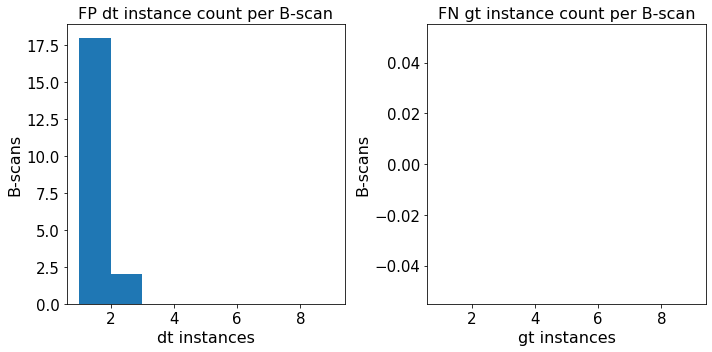

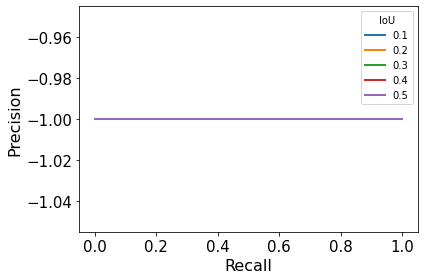

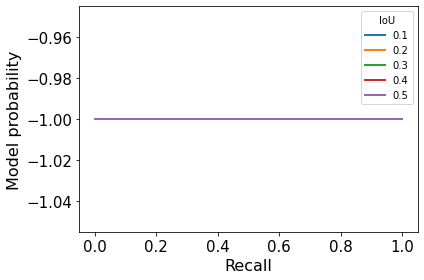

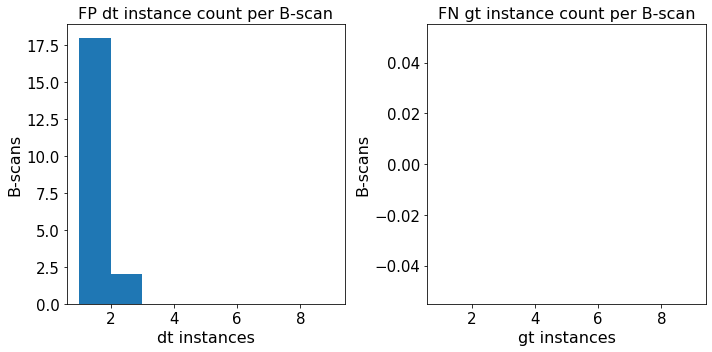

In [34]:
from plain_train_net import EvaluateClass,CreatePlotsRPD
import json
#evaluate ensemble
myeval = EvaluateClass(
    dataset_name, "output_"+ dataset_name,iou_thresh = .2,prob_thresh=0.5,evalsuper=False)
myeval.evaluate()
%precision 3
print(myeval.summarize_scalars())
with open(os.path.join("output_"+ dataset_name,'scalar_dict.json'),"w") as outfile:
    json.dump(obj=myeval.summarize_scalars(),fp=outfile)
num_images = myeval.num_images
myeval.plot_PRcurve()
plt.tight_layout()
myeval.plot_recall_vs_prob()
plt.tight_layout()

RPDplt = CreatePlotsRPD.initfromcoco(myeval.mycoco,myeval.prob_thresh)
RPDplt.gt_dt_FP_FN_count()


## Individual Models

In [9]:
#evaluate individual models
import json
myeval.evalsuper=False
for mdl in ("fold1", "fold2", "fold3", "fold4","fold5"):
    myeval.reset()
    output_dir = "output_"+ dataset_name + "/"+mdl
    myeval._output_dir = output_dir
    myeval.evaluate()
    print(myeval.summarize_scalars())
    with open(os.path.join(output_dir,'scalar_dict.json'),"w") as outfile:
        json.dump(obj=myeval.summarize_scalars(),fp=outfile)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Calculated metrics for 1078 images
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.00s).
Using alternate calculation for fpr at instance score threshold of 0.5
{'dataset': 'reserves_fold1', 'precision': -1.0, 'recall': 0.0, 'fpr': 0.03432281971871225, 'iou': 0.2, 'probability': 0.5}
Using alternate calculation for fpr at instance score threshold of 0.5
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Calculated metrics for 1078 images
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.00s).
Using alternate calculation for fpr at instance score threshold of 0.5
{'d

In [13]:
import json, os
import pandas as pd
from table_styles import styles
mydicts=[]
for mdl in ['fold1','fold2','fold3','fold4','fold5']:
    output_dir = "output_"+ dataset_name + "/"+mdl
    with open(os.path.join(output_dir,'scalar_dict.json')) as f:
        mydicts.append(json.load(f))
with open(os.path.join("output_"+ dataset_name,'scalar_dict.json')) as f:
    mydicts.append(json.load(f))
dfr = pd.DataFrame(mydicts)
dfr = dfr.assign(fp = np.int32(dfr.fpr*num_images))
dfr = dfr.assign(model = ['1','2','3','4','5','ensemble'])
dfr = dfr[['model','fpr','fp','probability','dataset']]
pd.set_option('display.precision',3)
dfr.style.set_table_styles(styles).set_table_attributes('style="font-size: 17px"')

,model,fpr,fp,probability,dataset
0,1,0.034,36,0.500,reserves_fold1
1,2,0.023,24,0.500,reserves_fold1
2,3,0.022,23,0.500,reserves_fold1
3,4,0.027,28,0.500,reserves_fold1
4,5,0.023,24,0.500,reserves_fold1
5,ensemble,0.019,19,0.500,reserves_fold1


# Visualize Output

In [8]:
from plain_train_net import OutputVis

pred_file = "output_"+ dataset_name + "/coco_instances_results.json"
out_file = os.path.join("output_"+ dataset_name,'mean_score_nms_'+dataset_name+'.pdf')

# mdl = 'fold1'
# pred_file = os.path.join("output_"+ dataset_name,mdl,"coco_instances_results.json")
# out_file = os.path.join("output_"+ dataset_name,'mean_score_nms_'+mdl+'.pdf')

vis = OutputVis(dataset_name,prob_thresh = 0.5,pred_mode='file',pred_file=pred_file,has_annotations=False)
ImgIds = RPDplt.dfimg.index[RPDplt.dfimg.dt_instances>0] #np.abs(df.gt_xpxs-df.dt_xpxs).sort_values(ascending=False).index[0:50].values
vis.output_to_pdf(ImgIds,out_file)


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


In [33]:
import pandas as pd
from table_styles import styles
df = pd.read_csv('/data/amd-data/cera-rpd/cera-rpd-train/data_RPDHimeesh_drusen_reserves/dffolds.csv').set_index('ptid')
grp = df.groupby('fold')
grp2 = df.reset_index().groupby('fold')
grp3 = df.reset_index().groupby(['fold','ptid','eye']).size().groupby('fold')
dfsummary = pd.concat([grp2[['scan','ptid']].nunique(),grp3.size().to_frame('eye'),grp.sum()],axis=1)
dfsummary

dfsummary.style.set_table_styles(styles).set_table_attributes('style="font-size: 17px"')

,scan,ptid,eye,yellow,white,red,black
fold,,,,,,,
fold1,1078,11,22,0.000000,0.000000,0.000000,547520512.000000
fold2,1176,12,24,0.000000,0.000000,0.000000,597295104.000000
fold3,1274,13,26,0.000000,0.000000,0.000000,647069696.000000
